In [5]:
# Cell 1: Imports and SparkSession
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from pyspark.mllib.linalg.distributed import RowMatrix

# Khởi tạo SparkSession với chaining đúng cách
spark = (
    SparkSession.builder
    .appName('GoldPricePrediction')
    .getOrCreate()
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Cell 2: Load dataset
# Đọc CSV với header, infer schema
df = spark.read.csv('/content/drive/MyDrive/Predict gold-price/gold_prices.csv', header=True, inferSchema=True)
# Đổi tên cột để có tên không chứa khoảng trắng
df = df.withColumnRenamed('Buy Price', 'BuyPrice') \
       .withColumnRenamed('Sell Price', 'SellPrice') \
       .withColumn('Date', F.to_date('Date', 'dd/MM/yyyy'))
# Sắp xếp theo ngày
df = df.orderBy('Date')

In [7]:
# Cell 3: Tạo lag features (t-10 đến t-1) trên cột BuyPrice
window = Window.orderBy('Date')
for i in range(1, 11):
    df = df.withColumn(f'lag_{i}', F.lag('BuyPrice', i).over(window))
# Loại bỏ các dòng đầu chưa có đủ 10 ngày trước
df_clean = df.na.drop(subset=[f'lag_{i}' for i in range(1, 11)])
df_clean = df.na.drop(subset=[f'lag_{i}' for i in range(1, 11)])

In [8]:
# Cell 4: Tạo feature vector và label (sử dụng BuyPrice)
assembler = VectorAssembler(
    inputCols=[f'lag_{i}' for i in range(1, 11)],
    outputCol='features'
)
df_features = assembler.transform(df_clean).select('features', F.col('BuyPrice').alias('label'))

In [9]:
# Cell 5: Chia train/test 70:30
train_df, test_df = df_features.randomSplit([0.7, 0.3], seed=42)


In [10]:
# Cell 6: Khởi tạo LinearRegression
# Chọn solver l-bfgs để thu được lịch sử loss qua nhiều iteration
lr = LinearRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=50,
    regParam=0.1,
    solver='l-bfgs'
)

In [11]:
# Cell 7: Huấn luyện model
lr_model = lr.fit(train_df)
train_summary = lr_model.summary


In [12]:
# Cell 8: Đánh giá trên tập train và test
# Train metrics
train_rmse = train_summary.rootMeanSquaredError
train_mse = train_summary.meanSquaredError
# Test metrics
test_summary = lr_model.evaluate(test_df)
test_rmse = test_summary.rootMeanSquaredError
test_mse = test_summary.meanSquaredError

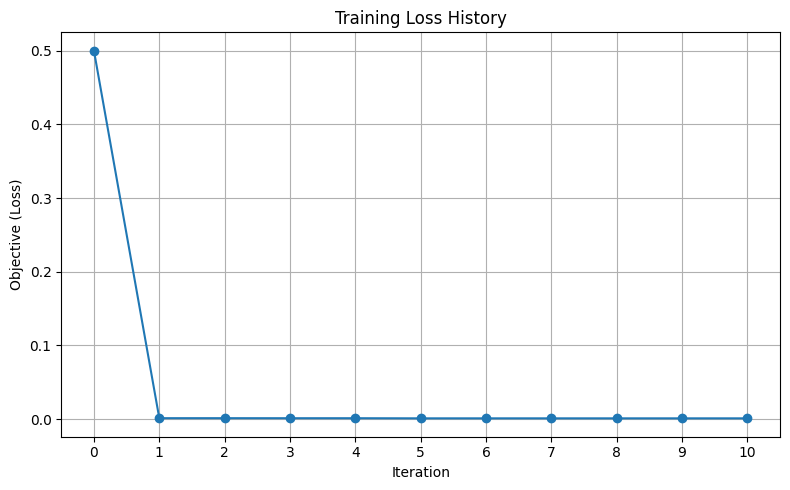

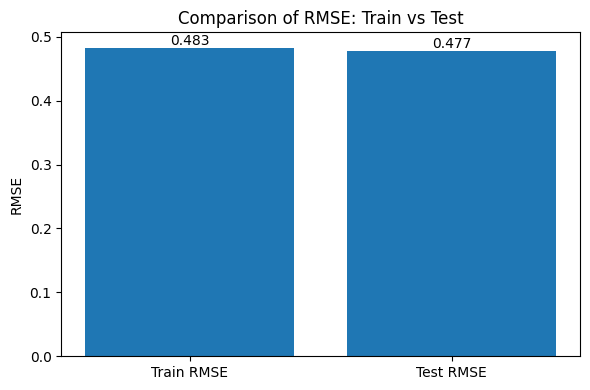

In [13]:
# Cell 9: Vẽ line chart loss trong quá trình huấn luyện (với trục x rõ ràng)
loss_history = train_summary.objectiveHistory
iterations = list(range(len(loss_history)))
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_history, marker='o')
plt.xticks(iterations)
plt.xlabel('Iteration')
plt.ylabel('Objective (Loss)')
plt.title('Training Loss History')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cell 10: Bar chart so sánh RMSE train và test
metrics = ['Train RMSE', 'Test RMSE']
values = [train_rmse, test_rmse]
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', ha='center', va='bottom')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE: Train vs Test')
plt.tight_layout()
plt.show()

